# Semi Gradient  n-step SARSA

In this notebook, we will be using n-step SARSA with function approximation using Tiles to solve Mountain Car Environment.

![nStepSARSA](./images/nstepSarsa.png "n-Step SARSA")

### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle
# !apt-get update 
# !apt-get install -y swig cmake ffmpeg freeglut3-dev xvfb

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab or Kaggle

## Uncomment and run for Colab
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /content/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter5


## Uncomment and run for Kaggle
# !git clone https://github.com/nsanghi/drl-2ed
# %cd /kaggle/working/drl-2ed 
# !pip install  -r requirements.txt
# %cd chapter5

In [ ]:
## Uncomment and Rerun the cd command in case you were asked to restart the kernel and you followed that message
## as after resart the kernel will again point back to root folder


## Uncomment and run for Colab
# %cd /content/drl-2ed 
# %cd chapter6


## Uncomment and run for Kaggle
# %cd /kaggle/working/drl-2ed 
# %cd chapter6

#### Imports

In [1]:
# Initial imports and environment setup
import gymnasium as gym
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from IPython.display import HTML
from base64 import b64encode

%matplotlib inline

2023-10-15 16:30:59.748111: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 16:31:00.108403: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-15 16:31:00.108453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-15 16:31:00.110563: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-15 16:31:00.249613: I tensorflow/core/platform/cpu_feature_g

### Mountain Car Environment

Mountain Car Environment


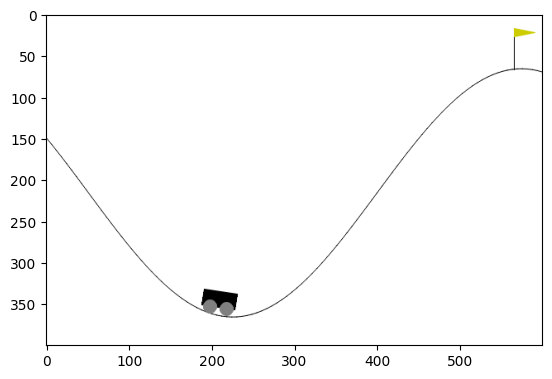

In [2]:
env = gym.make('MountainCar-v0', render_mode="rgb_array") # rest of the code is designed to work only for this environment. It will require change for other environments

# increase episode length from 200 to 4000
env._max_episode_steps = 4000

np.random.seed(13)
env.reset()
print("Mountain Car Environment")
plt.imshow(env.render())

In [3]:
# the implementation of tiles3 is from Richard Sutton's website
# http://incompleteideas.net/tiles/tiles3.html
from tiles3 import IHT, tiles

### The Agent

In [4]:
class QEstimator:

    def __init__(self, step_size, num_of_tilings=8, tiles_per_dim=8, max_size=2048, epsilon=0.0):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.tiles_per_dim = tiles_per_dim
        self.epsilon = epsilon
        self.step_size = step_size / num_of_tilings
        
        self.table = IHT(max_size)
        
        self.w = np.zeros(max_size)
        
        self.pos_scale = self.tiles_per_dim / (env.observation_space.high[0] \
                                                  - env.observation_space.low[0])
        self.vel_scale = self.tiles_per_dim / (env.observation_space.high[1] \
                                                  - env.observation_space.low[1])
        
    def get_active_features(self, state, action):
        pos, vel = state
        active_features = tiles(self.table, self.num_of_tilings,
                            [self.pos_scale * (pos - env.observation_space.low[0]), 
                             self.vel_scale * (vel- env.observation_space.low[1])],
                            [action])
        return active_features
        
    def q_predict(self, state, action):
        pos, vel = state
        if pos == env.observation_space.high[0]:  # reached goal
            return 0.0
        else:
            active_features = self.get_active_features(state, action)
            return np.sum(self.w[active_features])
        
    
    # learn with given state, action and target
    def q_update(self, state, action, target):
        active_features = self.get_active_features(state, action)
        q_s_a = np.sum(self.w[active_features])
        delta = (target - q_s_a)
        self.w[active_features] += self.step_size * delta
        
    def get_eps_greedy_action(self, state):
        pos, vel = state
        if np.random.rand() < self.epsilon:
            return np.random.choice(env.action_space.n)
        else:
            qvals = np.array([self.q_predict(state, action) for action in range(env.action_space.n)])
            return np.argmax(qvals)
        
    def get_action(self, state):
        pos, vel = state
        qvals = np.array([self.q_predict(state, action) for action in range(env.action_space.n)])
        return np.argmax(qvals) 

### n-step SARSA Rewards

In [5]:
def sarsa_n(qhat, step_size=0.5, epsilon=0.0, n=1, gamma=1.0, episode_cnt = 10000):
    episode_rewards = []
    for _ in range(episode_cnt):
        state,_ = env.reset()
        action = qhat.get_eps_greedy_action(state)
        T = float('inf')
        t = 0
        states = [state]
        actions = [action]
        rewards = [0.0]
        while True:
            if t < T:
                next_state, reward, terminated, _, _ = env.step(action)
                states.append(next_state)
                rewards.append(reward)
                
                if terminated:
                    T = t+1
                else:
                    next_action = qhat.get_eps_greedy_action(next_state)
                    actions.append(next_action)

            tau = t - n + 1
            
            if tau >= 0:
                G = 0
                for i in range(tau+1, min(tau+n, T)+1):
                    G += gamma ** (i-tau-1) * rewards[i]
                if tau+n < T:
                    G += gamma**n * qhat.q_predict(states[tau+n], actions[tau+n])
                qhat.q_update(states[tau], actions[tau], G)
            
            if tau == T - 1:
                episode_rewards.append(np.sum(rewards))
                break
            else:
                t += 1
                state = next_state
                action = next_action
    
    return np.array(episode_rewards)

### Return Plotting

In [6]:
# plot returns per episode
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean Return/episode = {:.1f}".format(env_name,
                                                    np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-500, 0)
    plt.xlabel("Episode number")
    plt.ylabel("Return per episode")
    plt.show()

### Recording Video of Agent

In [7]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])    
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()    
    for _ in range(video_length + 1):
        action = agent.get_action(obs[0])
        obs, _, _, _ = vec_env.step([action])
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]   
    # Save the video
    vec_env.close()
    return file_path

### Train Agent and Plot returns

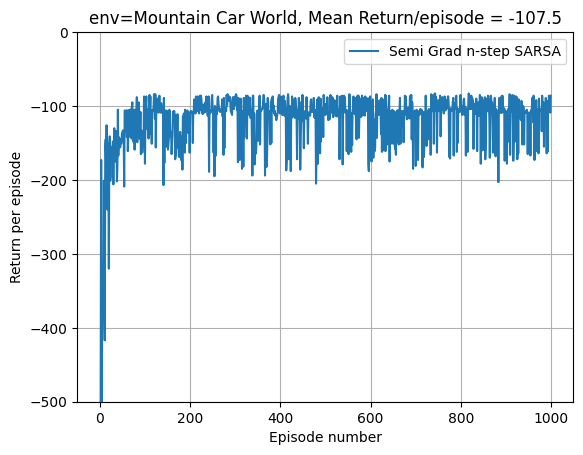

In [8]:
# create a n-SARSA Learning agent
step_size = 0.8
episode_cnt = 1000
n=4
epsilon= 0.0
gamma = 1.0

estimator = QEstimator(step_size, epsilon=epsilon)
rewards = sarsa_n(estimator, step_size=step_size, epsilon=epsilon, n=n, gamma=gamma, episode_cnt = episode_cnt)

#plot rewards
plot_rewards("Mountain Car World",rewards, 'Semi Grad n-step SARSA')

### Watch Trained Agent

In [9]:
env_id = "MountainCar-v0"
video_folder = "logs/videos/n-step/"
video_length = 500

agent = estimator
               
video_file = record_video(env_id, video_folder, video_length, agent)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter5/logs/videos/n-step/QEstimator-MountainCar-v0-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter5/logs/videos/n-step/QEstimator-MountainCar-v0-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter5/logs/videos/n-step/QEstimator-MountainCar-v0-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter5/logs/videos/n-step/QEstimator-MountainCar-v0-step-0-to-step-500.mp4


In [10]:
mp4 = open(video_file, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Close Environment

In [11]:
env.close()